In [2]:
import torch
import transformers
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from torch.utils.data import DataLoader
from torchvision.transforms import v2
import os
import pprint
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

In [3]:
transformers.__version__, torch.__version__

('4.40.2', '2.3.1')

In [4]:
# Device and paths:
device = 'cuda'
physionet_dir = '/datasets/work/hb-mlaifsp-mm/work/archive/physionet.org/files'  # Where MIMIC-CXR, MIMIC-CXR-JPG, and MIMIC-IV-ED are stored.
database_dir = '/scratch3/nic261/database/cxrmate_ed'  # The LMDB database for the JPGs and the DuckDB database for the tables will be saved here.

In [5]:
# Download model checkpoint:
model = transformers.AutoModel.from_pretrained('aehrc/cxrmate-ed', trust_remote_code=True).to(device=device)
model.eval()

# Download tokenizer:
tokenizer = transformers.PreTrainedTokenizerFast.from_pretrained('aehrc/cxrmate-ed')
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

/scratch3/nic261/environments/cxrmate_ed/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/scratch3/nic261/environments/cxrmate_ed/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [6]:
# Image transforms:
image_size = 384
test_transforms = v2.Compose(
    [
        v2.Grayscale(num_output_channels=3),
        v2.Resize(
            size=image_size, 
            antialias=True,
            interpolation=v2.InterpolationMode.BICUBIC,
        ),
        v2.CenterCrop(size=[image_size, image_size]),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD),
    ]
)

In [7]:
# Prepare the MIMIC-CXR & MIMIC-IV-ED dataset:
model.prepare_data(
    physionet_dir=physionet_dir,
    database_dir=database_dir,
)

# Get the test set dataset & dataloader:
test_set = model.get_dataset(split='test', transforms=test_transforms, database_dir=database_dir)
test_dataloader = DataLoader(
    test_set,
    batch_size=1, 
    num_workers=5,
    shuffle=True,  # Shuffle so that a different example is shown everytime the notebook is ran.
    collate_fn=model.collate_fn,
    pin_memory=True,
)

Loading images using LMDB.
No. of examples: 1624.
No. of training dicom_ids, study_ids, & subject_ids: 2872, 1624, & 280.


In [8]:
# Get an example:
batch = next(iter(test_dataloader))
        
# Show the batch:
pp = pprint.PrettyPrinter(indent=2)
pp.pprint(batch)

{ 'edstays_index_value_feats': tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 1., 0., 0., 0., 0.]]]),
  'edstays_index_value_mask': tensor([[1]], dtype=torch.int32),
  'edstays_index_value_time_delta': tensor([[[0.9129]]]),
  'edstays_index_value_token_type_ids': tensor([[1]]),
  'findings': [ 'Right atrial and biventricular pacemaker courses in expected '
                'position. No significant pleural effusions or pneumothorax. '
                'Moderate-to-severe cardiomegaly is unchanged. Mild central '
                'venous congestion and cephalization, but no frank edema. Tiny '
                'bilateral pleural effusions. There is no focal consolidation. '
                'Old healed rib fractures are present on the left.'],
  'image_time_deltas': [[1.0]],
  'images': tensor([[[[[-2.0152, -2.0152, -2.0323,  ..., -1.9980, -1.9980, -1.9809],
           [

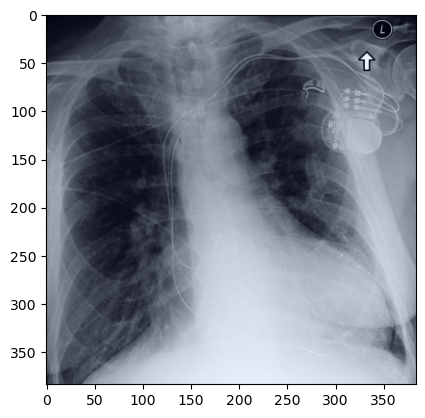

In [9]:
# Show the images for the study:
plt.imshow(make_grid(batch['images'][0], normalize=True).permute(1, 2, 0))

In [10]:
# Move tensors in the batch to the device:
for key, value in batch.items():
    if isinstance(value, torch.Tensor):
        batch[key] = value.to(device)

In [11]:
# Convert the patient data in the batch into embeddings:
inputs_embeds, attention_mask, token_type_ids, position_ids, bos_token_ids = model.prepare_inputs(tokenizer=tokenizer, **batch)
    
# Generate reports:
output_ids = model.generate(
    input_ids=bos_token_ids,
    decoder_inputs_embeds=inputs_embeds,
    decoder_token_type_ids=token_type_ids,
    prompt_attention_mask=attention_mask,
    prompt_position_ids=position_ids,
    special_token_ids=[tokenizer.sep_token_id],
    token_type_id_sections=model.decoder.config.section_ids,
    max_length=256,
    num_beams=4,
    return_dict_in_generate=True,
)['sequences']


In [12]:
# Findings and impression section:
findings, impression = model.split_and_decode_sections(output_ids, [tokenizer.sep_token_id, tokenizer.eos_token_id], tokenizer)
for i,j in zip(findings, impression):
    print(f'Findings:\t{i}\nImpression:\t{j}\n\n')

Findings:	Left-sided pacemaker device is again noted with leads terminating in the right atrium and right ventricle. Moderate cardiomegaly is again noted. The mediastinal and hilar contours are stable. There is no pulmonary edema. There are mild interstitial opacities at the lung bases, which may be reflective of mild atelectasis. No focal consolidation. No pleural effusion or pneumothorax is seen.
Impression:	No acute cardiopulmonary process.


